# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0 

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [3]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [4]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(60, 6)


,title,price,year,link,brand,age
0,1981 volkswagen diesel rabbit - pickup - runni...,6500,1981.0,https://charlottesville.craigslist.org/cto/d/c...,volkswagen,44.0
1,2007 nissan altima s,2900,2007.0,https://charlottesville.craigslist.org/cto/d/c...,missing,18.0
2,2012 jeep patriot 4x4,6250,2012.0,https://charlottesville.craigslist.org/cto/d/l...,jeep,13.0
3,2010 honda odessey,3000,2010.0,https://charlottesville.craigslist.org/cto/d/p...,honda,15.0
4,2008 kia sedona lx 4door,2500,2008.0,https://charlottesville.craigslist.org/cto/d/b...,kia,17.0


With the data in and wrangled, we can now do some analysis:

count       60.000000
mean      9719.983333
std      10887.409492
min        500.000000
25%       3725.000000
50%       6375.000000
75%      10762.500000
max      62800.000000
Name: price, dtype: float64


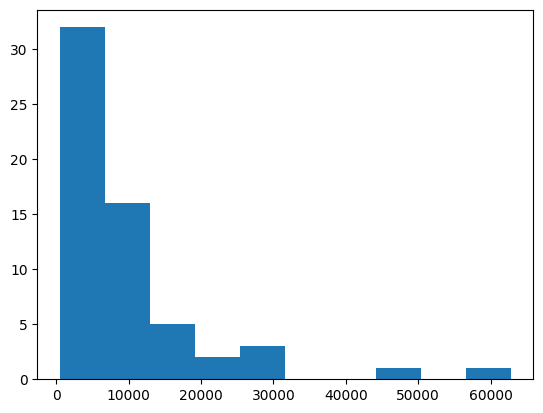

count    54.000000
mean     22.166667
std      15.301683
min       4.000000
25%      13.000000
50%      17.500000
75%      24.250000
max      68.000000
Name: age, dtype: float64


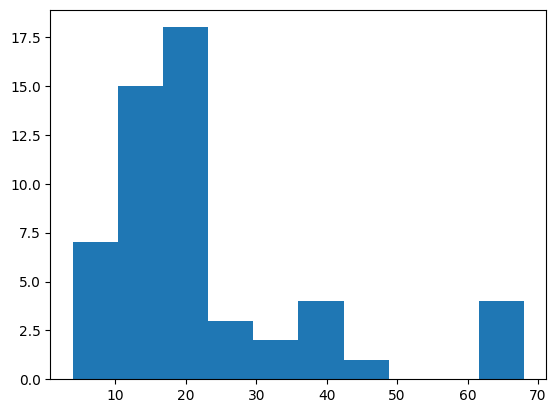

In [5]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [6]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        1.0   7500.000000           NaN   7500.0   7500.0   7500.0   
audi         1.0  11000.000000           NaN  11000.0  11000.0  11000.0   
bmw          3.0   8500.000000   1322.875656   7500.0   7750.0   8000.0   
chevrolet    2.0  18500.000000   5656.854249  14500.0  16500.0  18500.0   
chevy        4.0   2675.000000   1584.034932    500.0   2300.0   2950.0   
dodge        1.0   4000.000000           NaN   4000.0   4000.0   4000.0   
ford         6.0  16291.666667  17104.397583   4000.0   5937.5  10375.0   
gmc          2.0  16500.000000  13435.028843   7000.0  11750.0  16500.0   
honda        8.0  10500.000000   8405.440415   3000.0   5600.0   7200.0   
jeep         3.0   8150.000000   1693.369422   6250.0   7475.0   8700.0   
kia          1.0   2500.000000           NaN   2500.0   2500.0   2500.0   
lexus        2.0  11175.000000    318.198052  10950.0  11062.5  11175.0   
mazda        1.0   3000.000000           NaN   3000.0   3000.0   3000.0   
missing     17.0   9014.647059  14771.513662   2250.0   3500.0   3800.0   
mitsubishi   1.0   6800.000000           NaN   6800.0   6800.0   6800.0   
subaru       1.0   3950.000000           NaN   3950.0   3950.0   3950.0   
tesla        1.0  26900.000000           NaN  26900.0  26900.0  26900.0   
toyota       3.0   6800.000000   3395.585369   4500.0   4850.0   5200.0   
volkswagen   2.0   4575.000000   2722.361108   2650.0   3612.5   4575.0   

                              
                75%      max  
brand                         
acura        7500.0   7500.0  
audi        11000.0  11000.0  
bmw          9000.0  10000.0  
chevrolet   20500.0  22500.0  
chevy        3325.0   4300.0  
dodge        4000.0   4000.0  
ford        16875.0  49500.0  
gmc         21250.0  26000.0  
honda       13250.0  29000.0  
jeep         9100.0   9500.0  
kia          2500.0   2500.0  
lexus       11287.5  11400.0  
mazda        3000.0   3000.0  
missing      5250.0  62800.0  
mitsubishi   6800.0   6800.0  
subaru       3950.0   3950.0  
tesla       26900.0  26900.0  
toyota       7950.0  10700.0  
volkswagen   5537.5   6500.0

In [7]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                     
           count       mean        std   min    25%   50%   75%   max
brand                                                                
acura        1.0  11.000000        NaN  11.0  11.00  11.0  11.0  11.0
audi         1.0   8.000000        NaN   8.0   8.00   8.0   8.0   8.0
bmw          3.0  15.666667   1.527525  14.0  15.00  16.0  16.5  17.0
chevrolet    2.0  52.000000  22.627417  36.0  44.00  52.0  60.0  68.0
chevy        3.0  31.333333  10.503968  21.0  26.00  31.0  36.5  42.0
dodge        1.0  22.000000        NaN  22.0  22.00  22.0  22.0  22.0
ford         6.0  16.333333   6.408328   8.0  11.50  17.5  22.0  22.0
gmc          1.0  41.000000        NaN  41.0  41.00  41.0  41.0  41.0
honda        8.0  12.125000   4.611709   4.0  10.25  12.5  15.0  19.0
jeep         3.0  14.333333   3.214550  12.0  12.50  13.0  15.5  18.0
kia          1.0  17.000000        NaN  17.0  17.00  17.0  17.0  17.0
lexus        2.0  17.000000   5.656854  13.0  15.00  17.0  19.0  21.0
mazda        1.0  17.000000        NaN  17.0  17.00  17.0  17.0  17.0
missing     14.0  29.357143  20.812744   7.0  14.25  23.0  34.5  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.0  17.0
subaru       0.0        NaN        NaN   NaN    NaN   NaN   NaN   NaN
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.0   7.0
toyota       3.0  21.000000   4.000000  17.0  19.00  21.0  23.0  25.0
volkswagen   2.0  33.000000  15.556349  22.0  27.50  33.0  38.5  44.0

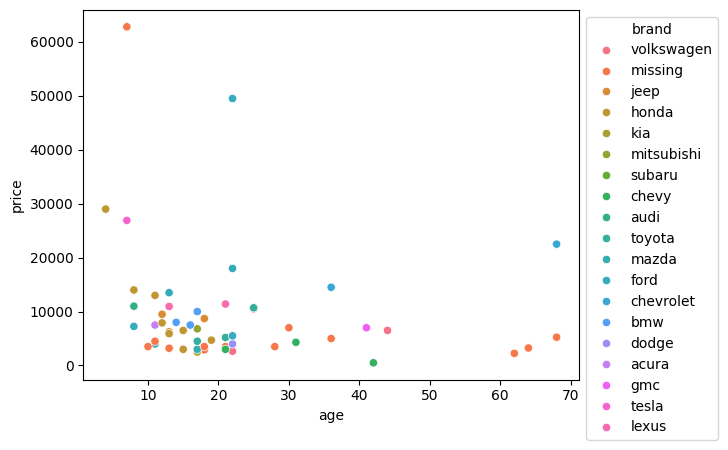

In [8]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.690003 -0.175567
log_age    -0.175567  0.366501
           log_price   log_age
log_price   1.000000 -0.352727
log_age    -0.352727  1.000000


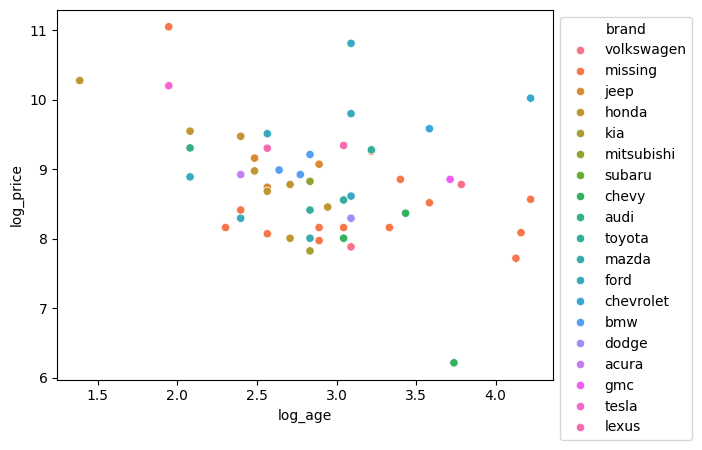

In [9]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/ppa?purveyor=owner#search=1~gallery~0~0' # The appliance page we want to scrape
raw = requests.get(url,headers=header) # Get page

from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
ap_listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

In [47]:
import re # Regular expressions

appliances = ['refrigerator', 'microwave','kettle','fryer','dishwasher','sink','toaster','oven','freezer',
          'stove','grill','dryer','blender','food processor','juicer','vacuums','sewing machine', 'cooker', 'cords', 'coffee'] #list of possible appliances

ap_data = [] # We'll save our listings in this object
for k in range( len(ap_listings) ):
    title = ap_listings[k].find('div',class_='title').get_text().strip().lower()
    price = ap_listings[k].find('div',class_='price').get_text()
    link = ap_listings[k].find(href=True)['href']
    words = title.split()
    hits = [word for word in words if word in appliances] # Find appliances in the title
    if len(hits) == 0:
        appliance = 'missing'
    else:
        appliance = hits[0]
    
    ap_data.append({'title':title,'price':price,'link':link,'appliance': appliance})


In [53]:
## Wrangle the data
ap_df = pd.DataFrame.from_dict(ap_data)
ap_df['price'] = ap_df['price'].str.replace('$','')
ap_df['price'] = pd.to_numeric(ap_df['price'],errors='coerce')
print(ap_df.shape)
ap_df.to_csv('./src/craigslist_cville_appliances.csv') # Save data in case of a disaster
ap_df.head()

(64, 4)


,title,price,link,appliance
0,kenmore refrigerator $50,50.0,https://charlottesville.craigslist.org/app/d/l...,refrigerator
1,air fryer,60.0,https://charlottesville.craigslist.org/app/d/c...,fryer
2,kitchen appliances and vacuums,1.0,https://charlottesville.craigslist.org/app/d/c...,vacuums
3,new elite gourmet crock pot slow cooker,25.0,https://charlottesville.craigslist.org/app/d/c...,cooker
4,for sale: frigidaire ffra051wae window-mounted...,125.0,https://charlottesville.craigslist.org/app/d/w...,missing


count     61.000000
mean     186.770492
std      196.814328
min        0.000000
25%       50.000000
50%      120.000000
75%      275.000000
max      800.000000
Name: price, dtype: float64


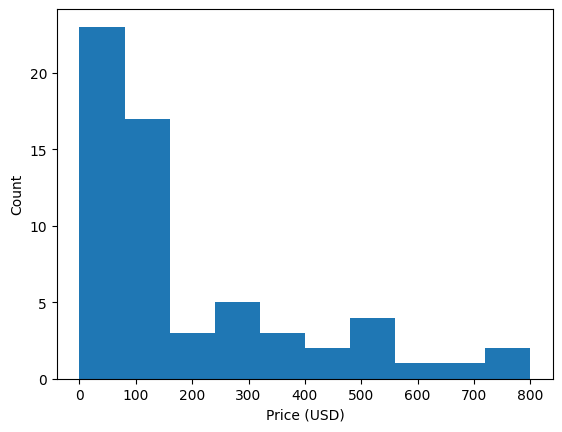

             price                                                        \
             count        mean         std    min     25%    50%     75%   
appliance                                                                  
coffee         3.0   55.000000   57.662813    0.0   25.00   50.0   82.50   
cooker         2.0   27.500000    3.535534   25.0   26.25   27.5   28.75   
cords          1.0   15.000000         NaN   15.0   15.00   15.0   15.00   
dishwasher     3.0  323.333333  251.014608  100.0  187.50  275.0  435.00   
dryer          5.0  302.000000   94.644070  150.0  285.00  325.0  350.00   
freezer        3.0  243.333333  160.104133   80.0  165.00  250.0  325.00   
fryer          2.0  430.000000  523.259018   60.0  245.00  430.0  615.00   
microwave      4.0   98.500000   56.026779   20.0   80.00  112.5  131.00   
missing       28.0  169.392857  185.925780    0.0   45.00  109.5  207.50   
oven           1.0  275.000000         NaN  275.0  275.00  275.0  275.00   
refrigerator

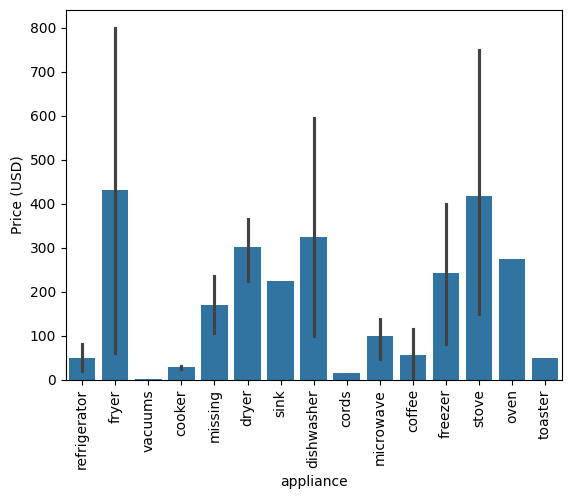

In [55]:
#Looking at appliance price summary
print(ap_df['price'].describe())
ap_df['price'].hist(grid=False)
plt.ylabel("Count")
plt.xlabel("Price (USD)")
plt.show()

#Grouping appliances by price
print(ap_df.loc[:,['price','appliance']].groupby('appliance').describe())

#Comparing appliance prices
ax = sns.barplot(data=ap_df, x='appliance', y='price')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Price (USD)")

#Conclusion
print("The appliance titles were a bit messier/less consistent than the car data so it was more difficult to group items.\n", 
      "I thought it was interesting that dryers were the most common appliance and that some people were even selling dishwashers.\n",
      "In the first barplot, we see that most items are between $1-100 but some items even go up to $800. The higher value items \n",
      "mostly consisted of fryers and ovens (with high variability in price), as we can see in the second barplot.\n", 
      "Items like cords, vaccuums, and kitchen cookers went for the lowest prices. ")